# FrozenLake - QLearning using TensorFlow and ANN

In QLearning we build ANN which will predict next action based on given state.
The network will learn how to map to the correct action using GradientDescent.

For this tutorial we will use [Frozen Lake](https://gym.openai.com/envs/FrozenLake-v0).

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import wrappers
import tensorflow as tf

logging.getLogger('gym').setLevel(logging.WARNING)

## Helper functions

In [2]:
# FrozenLake is solved if moving average over window size 100 is >= 0.78
def moving_average(xs, n=100):
    cs = np.cumsum(xs, dtype=float)
    cs[n:] = cs[n:] - cs[:-n]
    return cs[n - 1:] / n


def find_index(xs, v):
    """Find index of the first value equal or greater then v"""
    for i in range(len(xs)):
        if xs[i] >= v:
            return i
    return -1


## QNetwork Agent

This agent uses ANN with single layer.
The loss function is defined as:

$$\sum_{n=1}^{\infty}(Q_{next}-Q)^{2}$$

In [3]:
class QNetworkAgent:
    
    def __init__(self, num_states, num_actions, learning_rate, gamma):
        self.epsilon = 0.99
        self.gamma = gamma
        self.num_states = num_states
        self.num_actions = num_actions
        # Placeholders for state
        self.state = tf.placeholder(shape=[1, num_states], dtype=tf.float32)
        # Calculate Q values for given state
        self.W = tf.Variable(tf.random_uniform([num_states, num_actions], 0, 0.01))
        self.Q =  tf.matmul(self.state, self.W)
        # Select action with the highest score
        self.action_op = tf.argmax(self.Q, axis=1)
    
        # Prepare loss function
        # Placeholder for expected rewards
        self.Qnext = tf.placeholder(shape=[1, num_actions], dtype=tf.float32)
        self.loss = tf.reduce_sum(tf.square(self.Qnext - self.Q))
        self.train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss)
        # Prepare session
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
    
    
    def choose_action(self, state, progress):
        if np.random.rand() < self.epsilon * progress:
            s = self._encode_state(state)
            return self.sess.run(self.action_op, feed_dict={self.state: s})[0]
        else:
            return np.random.choice(range(self.num_actions))
    
    
    def learn(self, state, action, reward, next_state):
        s1 = self._encode_state(state)
        s2 = self._encode_state(next_state)
        Q_val = self.sess.run(self.Q, feed_dict={self.state: s1})
        Qnext_val = self.sess.run(self.Q, feed_dict={self.state: s2})[0]
        gradient = abs(Q_val[0, action] - reward + self.gamma * np.max(Qnext_val))
        Q_val[0, action] = reward + self.gamma * np.max(Qnext_val)
        self.sess.run(self.train_op, feed_dict={self.state: s1, self.Qnext: Q_val})
        return gradient
    
    
    def close(self):
        """It is better to close session."""
        self.sess.close()
        
        
    def _encode_state(self, state):
        """1-hot encoding for state"""
        return np.identity(self.num_states)[state:state+1]


## Train agent

Solved after 8483 episodes


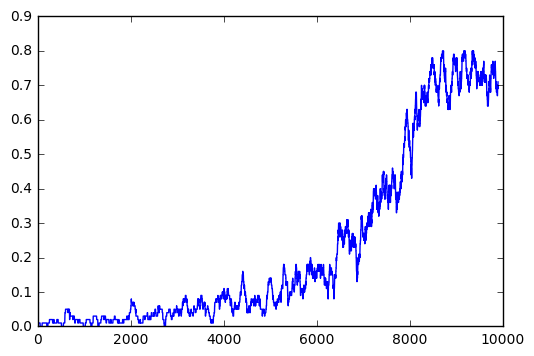

In [4]:
# Learning parameters
learning_rate = 0.1
gamma = 0.99
num_episodes = 10000
solved_score = 0.78

# Environment
env = gym.make('FrozenLake-v0')

# Agent
agent = QNetworkAgent(env.observation_space.n, env.action_space.n, learning_rate, gamma)

# Learn Q-Table
rewards = []
for episode in range(num_episodes):
    s = env.reset()
    total_reward = 0
    for j in range(1000):
        a = agent.choose_action(s, 1.2*episode/float(num_episodes))
        s2, reward, done, _ = env.step(a)
        agent.learn(s, a, reward, s2)
        s = s2
        total_reward += reward
        if done:
            break
    rewards.append(total_reward)
    
env.close()    
agent.close()

# Show summary
averaged_rewards = moving_average(rewards)    
idx = find_index(averaged_rewards, solved_score)
if idx >= 0:
    print('Solved after {} episodes'.format(idx+1))

plt.plot(averaged_rewards)
plt.show()